## Part 1
**Load data, process it, handle nans and outliers concurrently**

In [1]:
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import nest_asyncio

# Allow nested use of asyncio.run()
nest_asyncio.apply()

In [2]:
async def load_and_process_chunk(file_path: str) -> pd.DataFrame:
    # Load a single chunk
    df = pd.read_csv(
        file_path,
        low_memory=False,
    )

    # Combine Date and Time into a single datetime column and set as index
    df["dt"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
    df.set_index("dt", inplace=True)
    # Drop the original Date and Time columns
    df.drop(columns=["Date", "Time"], inplace=True)
    # Drop rows with missing values
    df.replace("?", np.nan, inplace=True)

    # set all columns as float
    for col in df.columns:
        df[col] = df[col].astype("float64")

    # Handle missing values by filling them with the median of each column
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            df[column].fillna(df[column].median(), inplace=True)

    # Step 5: Identify and Handle Outliers
    # Detect and handle outliers by capping at the 99th percentile
    upper_limit = df["Global_active_power"].quantile(0.99)
    df["Global_active_power"] = df["Global_active_power"].clip(upper=upper_limit)

    return df

In [3]:
async def process_data_parallel():
    chunk_files = [
        "C:/Afeka/Afeka_DL_course_labs/src/task_2/data/household_power_consumption_0.csv",
        "C:/Afeka/Afeka_DL_course_labs/src/task_2/data/household_power_consumption_207526.csv",
    ]  # Add paths to all chunk files
    tasks = [load_and_process_chunk(file) for file in chunk_files]
    results = await asyncio.gather(*tasks)

    # Concatenate all chunks into a single DataFrame
    full_df = pd.concat(results)
    return full_df

# Run the asynchronous processing
full_df = asyncio.run(process_data_parallel())

C:\Users\raniz\AppData\Local\Temp\ipykernel_12836\3609954217.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)
C:\Users\raniz\AppData\Local\Temp\ipykernel_12836\3609954217.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

**Plot basic stats on data**

In [4]:
def plot_dataframe_stats(df: pd.DataFrame):
    # Display basic info about the DataFrame
    print(df.info())
    print(df.head())

plot_dataframe_stats(full_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 415051 entries, 2006-12-16 17:24:00 to 2007-09-30 22:54:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    415051 non-null  float64
 1   Global_reactive_power  415051 non-null  float64
 2   Voltage                415051 non-null  float64
 3   Global_intensity       415051 non-null  float64
 4   Sub_metering_1         415051 non-null  float64
 5   Sub_metering_2         415051 non-null  float64
 6   Sub_metering_3         415051 non-null  float64
dtypes: float64(7)
memory usage: 25.3 MB
None
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00          

# Step 2: Visualize Time Series Trends

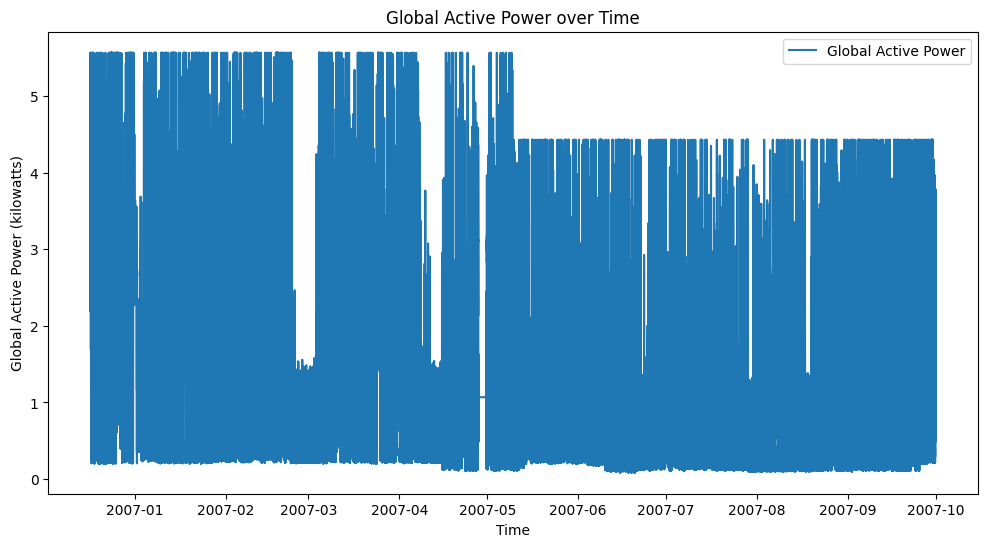

In [5]:
def visualize_time_series_trends(df: pd.DataFrame):
    # Plot Global_active_power over time
    plt.figure(figsize=(12, 6))
    plt.plot(df["Global_active_power"], label="Global Active Power")
    plt.xlabel("Time")
    plt.ylabel("Global Active Power (kilowatts)")
    plt.title("Global Active Power over Time")
    plt.legend()
    plt.show()


visualize_time_series_trends(full_df)

# Step 3: Check for Seasonality and Cyclical Patterns

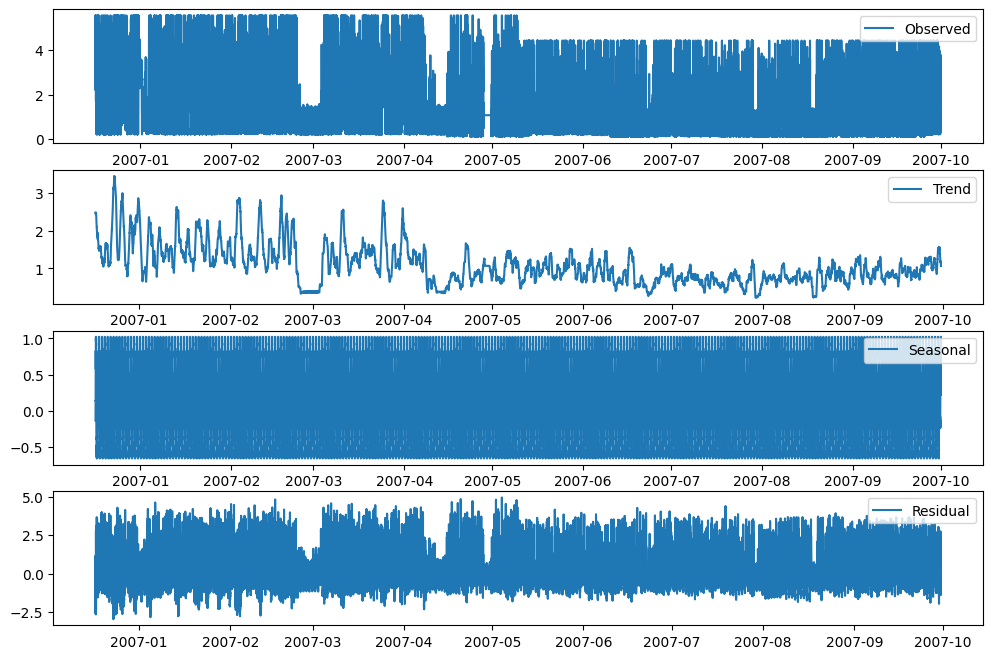

In [6]:
def check_seasonality_and_cyclical_patterns(df: pd.DataFrame):
    # Decompose the time series
    decomposition = seasonal_decompose(
        df["Global_active_power"].dropna(), model="additive", period=24 * 60
    )

    # Plot decomposition results
    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label="Observed")
    plt.legend(loc="upper right")
    plt.subplot(412)
    plt.plot(decomposition.trend, label="Trend")
    plt.legend(loc="upper right")
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label="Seasonal")
    plt.legend(loc="upper right")
    plt.subplot(414)
    plt.plot(decomposition.resid, label="Residual")
    plt.legend(loc="upper right")
    plt.show()


check_seasonality_and_cyclical_patterns(full_df)

# Step 4: Analyze Distribution of Power Consumption

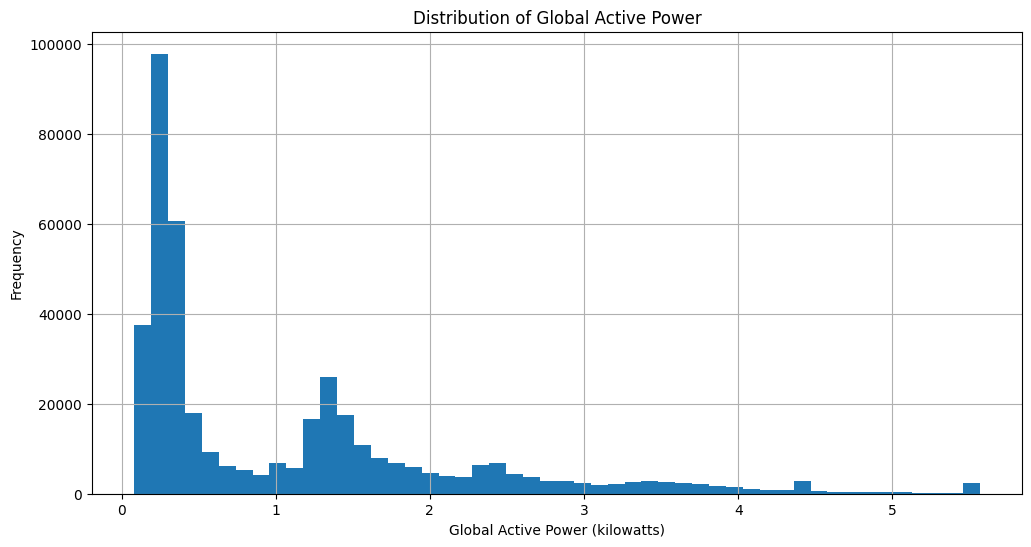

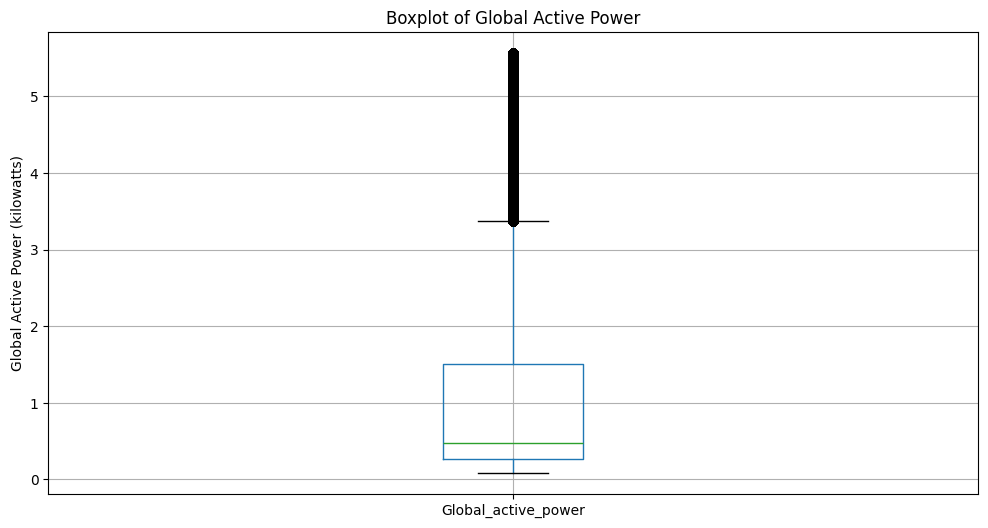

In [7]:
def analyze_distribution_of_power_consumption(df: pd.DataFrame):
    # Plot histogram
    plt.figure(figsize=(12, 6))
    df["Global_active_power"].hist(bins=50)
    plt.xlabel("Global Active Power (kilowatts)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Global Active Power")
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(12, 6))
    df.boxplot(column="Global_active_power")
    plt.ylabel("Global Active Power (kilowatts)")
    plt.title("Boxplot of Global Active Power")
    plt.show()

analyze_distribution_of_power_consumption(full_df)

# Implement a linear regression model to predict power consumption for the last three time periods

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [10]:

def split_data_append_lagged_features(full_df):
    # Create lagged features
    full_df["lag_1"] = full_df["Global_active_power"].shift(1)
    full_df["lag_2"] = full_df["Global_active_power"].shift(2)
    full_df["lag_3"] = full_df["Global_active_power"].shift(3)

    # Drop any rows with NaN values created by the shift operation
    full_df.dropna(inplace=True)

    # Define the target variable and features
    X = full_df[["lag_1", "lag_2", "lag_3"]]
    y = full_df["Global_active_power"]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print("Training set size:", X_train.shape)
    print("Testing set size:", X_test.shape)

    return X_train, X_test, y_train, y_test 

In [11]:
def run_linear_regression(X_train, y_train, X_test, y_test):
    # Initialize the models
    linear_reg = LinearRegression()

    # Train Linear Regression
    linear_reg.fit(X_train, y_train)

    return linear_reg

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = split_data_append_lagged_features(full_df)
linear_reg = run_linear_regression(X_train, y_train, X_test, y_test)

# Make predictions on the testing data
y_pred_lr = linear_reg.predict(X_test)

# Evaluation metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - MAE: {mae_lr}, MSE: {mse_lr}, R²: {r2_lr}")

Training set size: (332038, 3)
Testing set size: (83010, 3)
Linear Regression - MAE: 0.10913235054001645, MSE: 0.08711204111480439, R²: 0.9306432168724086


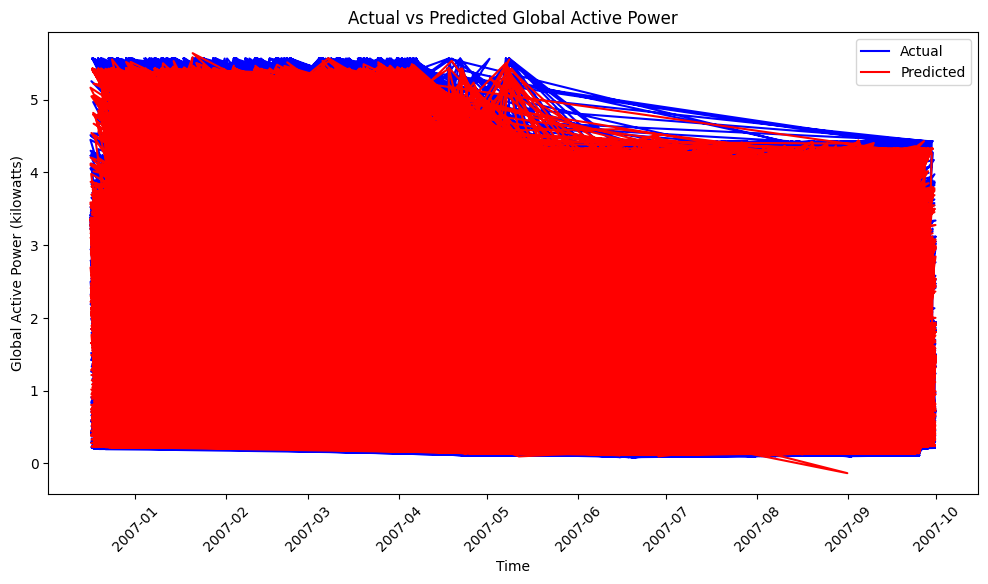

In [15]:
import matplotlib.pyplot as plt

# Ensure the index is datetime for the testing set
X_test_indexed = X_test.copy()
X_test_indexed['dt'] = y_test.index

# Plot predictions vs actual values with datetime on the x-axis
plt.figure(figsize=(12, 6))
plt.plot(X_test_indexed['dt'], y_test.values, label='Actual', color='blue')
plt.plot(X_test_indexed['dt'], y_pred_lr, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Actual vs Predicted Global Active Power')
plt.legend()
plt.xticks(rotation=45)
plt.show()


# Here you need to append the Entire RNN Notebook